In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv
from torchmetrics import Accuracy
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [1]:
from tqdm import tqdm

In [64]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr to rgb
        img = img.astype(np.float32)
        img = img / 255.0
        
        img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_AREA)
        
        img.transpose([2, 0, 1])
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        
        return {'img': t_img, 'label': t_class_id}

    

In [65]:
train_dogs_path = 'D:/matvei/datasets/dogs_and_cats/training_set/dogs'
train_cats_path = 'D:/matvei/datasets/dogs_and_cats/training_set/cats'

test_dogs_path = 'D:/matvei/datasets/dogs_and_cats/test_set/dogs'
test_cats_path = 'D:/matvei/datasets/dogs_and_cats/test_set/cats'


train_ds_catdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catdogs = Dataset2class(test_dogs_path, test_cats_path)


In [66]:
batch_size = 50


train_loader = torch.utils.data.DataLoader(
    train_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
    )

test_loader = torch.utils.data.DataLoader(
   test_ds_catdogs, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False
   )

In [119]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)
        
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out
                           )
        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv4(out)
        out = self.act(out)
  
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out
        
        

In [120]:
model = ConvNet()

In [121]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(DEVICE)

ConvNet(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=2, bias=True)
)

In [122]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

accuracy_metric = Accuracy(task='multiclass', num_classes=2).to(DEVICE)
losses_train = []
total_loss = []
acc_val = []

In [123]:
epochs = 8

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for sample in tqdm(train_loader):
        img, label = sample['img'], sample['label']
        optimizer.zero_grad()
        
        img = img.permute(0, 3, 1, 2).to(DEVICE)
        label = label.long().to(DEVICE)

        pred = model(img).squeeze(1) 
        
        loss = loss_fn(pred, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_metric(pred, label).item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)

    print(f'Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.5f}, Accuracy: {epoch_acc:.3f}')


100%|██████████| 160/160 [00:46<00:00,  3.43it/s]


Epoch [1/8] - Loss: 0.68636, Accuracy: 0.541


100%|██████████| 160/160 [00:46<00:00,  3.45it/s]


Epoch [2/8] - Loss: 0.65058, Accuracy: 0.629


100%|██████████| 160/160 [00:46<00:00,  3.47it/s]


Epoch [3/8] - Loss: 0.59926, Accuracy: 0.678


100%|██████████| 160/160 [00:45<00:00,  3.49it/s]


Epoch [4/8] - Loss: 0.54207, Accuracy: 0.730


100%|██████████| 160/160 [00:46<00:00,  3.47it/s]


Epoch [5/8] - Loss: 0.47455, Accuracy: 0.774


100%|██████████| 160/160 [00:45<00:00,  3.54it/s]


Epoch [6/8] - Loss: 0.43741, Accuracy: 0.793


100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


Epoch [7/8] - Loss: 0.39040, Accuracy: 0.823


100%|██████████| 160/160 [00:48<00:00,  3.32it/s]

Epoch [8/8] - Loss: 0.35063, Accuracy: 0.848


In [125]:
loss_fn = nn.CrossEntropyLoss()
accuracy_metric = Accuracy(task='multiclass', num_classes=2).to(DEVICE)

model.eval()
test_loss = 0.0
test_acc = 0.0

for sample in tqdm(test_loader):
    with torch.no_grad():
        img, label = sample['img'], sample['label']
        
        img = img.permute(0, 3, 1, 2).to(DEVICE)
        label = label.long().to(DEVICE) 
        pred = model(img)


        loss = loss_fn(pred, label)
        test_loss += loss.item()

        batch_acc = accuracy_metric(pred, label)
        test_acc += batch_acc.item()

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)

print(f'Test Loss: {avg_test_loss:.5f}, Test Accuracy: {avg_test_acc:.3f}')

100%|██████████| 40/40 [00:18<00:00,  2.13it/s]

Test Loss: 0.42348, Test Accuracy: 0.821


In [126]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [177]:
def lusa_test(lusa_path):   
    lusa = cv2.imread(lusa_path, cv2.IMREAD_COLOR)
    lusa = cv2.cvtColor(lusa, cv2.COLOR_BGR2RGB)
    plt.imshow(lusa)
    plt.title("Фото люси")
    plt.axis("off")
    plt.show()
    lusa1= lusa.astype(np.float32) 
    lusa = lusa / 255.0 
    lusa = cv2.resize(lusa, (100, 100), interpolation=cv2.INTER_AREA)
    lusa = lusa.transpose([2, 0, 1])
    lusa_t = torch.from_numpy(lusa).unsqueeze(0) 
    lusa_class_id = torch.tensor(1)
    with torch.no_grad():
        lusa_t = lusa_t.float().to(DEVICE)
        lusa_class_id = lusa_class_id.long().to(DEVICE)
        pred = model(lusa_t)


        probabilities = F.softmax(pred, dim=1) 

        cat_probability = probabilities[0, 1].item()  

    print(f"Это кошка с вероятностью {cat_probability:.3f}")

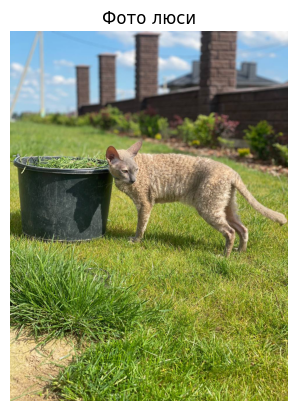

Это кошка с вероятностью 0.946


In [179]:
path_lusa_1 = 'D:/matvei/datasets/dogs_and_cats/true_imgs/lusa1.jpg'
lusa_test(path_lusa_1)